In [1]:
!pip install pandas numpy sklearn matplotlib tensorly openpyxl keras scipy tensorflow

In [299]:
##Here is the required python functions to run this notebook
##The main packages used are sklearn, tensorly, pandas, matplotlib and numpy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, FastICA, NMF
import tensorly as tl
from tensorly.decomposition import tucker,non_negative_tucker,parafac,non_negative_parafac
from tensorly import tucker_to_tensor
from tensorly.cp_tensor import cp_to_tensor
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.integrate as integrate
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

Text(0, 0.5, 'EMG amplitude')

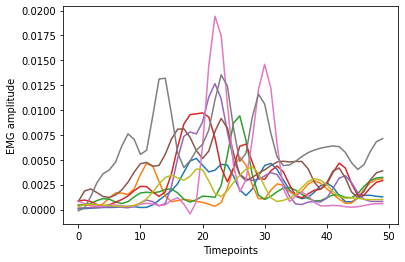

In [21]:
##Data preperation

#The first step in any analytical approach is to get to know your data. For this sample sheet, we are using a dataset 
#of nine EMG channels recorded across the right arm and torso during point-to-point backward and forwards reaching movements 
#(see https://doi.org/10.1152/jn.00245.2013 for details on the data collection). 
#In the following code, we will import this data for a single subject across 640 trials 
#(320 in the forward direction, 320 in the backwards direction) using the pandas package.

X=pd.read_excel('Machine_Learning_tutorials/EMG_daven1.xlsx')

#Inspect the data on a trial-to-trial basis by reshaping the 2D matrix into a 3D tensor. Each trial consists of 50
#timepoints, therefore we need to produce a 640 trial x 50 timepoint x 9 muscle tensor in the following way:

X_tensor=X.values.reshape(640,50,9)

#Plot a single trial to inspect the quality and interpretability of the EMG recordings using the matplotlib library:
trial=10
plt.plot(X_tensor[trial,:,:])
plt.xlabel('Timepoints')
plt.ylabel('EMG amplitude')

In [25]:
#It is important when interpreting the data that it is put in the context of the motor behavior being performed.
#So now we will import three task variables that categorise the above data based on the following events:
    #TASK = All reaching movements in both directions and at fast and slow speeds.
        #(1-4= forward reaching at a slow speed, 5-8= backward reaching at a slow speed, 9-12=forward reaching at a fast pace,
        #13-16= backward reaching at a fast pace
    #Speed = Fast or slow reaching speeds.
    #Direction = Forward or backwards direction

Y=pd.read_excel('Machine_Learning_tutorials/trg.xlsx')
Y

,TASK,Speed,Direction
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
635,16,1,1
636,16,1,1
637,16,1,1
638,16,1,1


Muscles included:  ['BR', 'BI', 'TM']
Slow trials selected..
Forward reaching direction selected...
(50, 9)
Reaching point 1 selected...
Averaging across trials


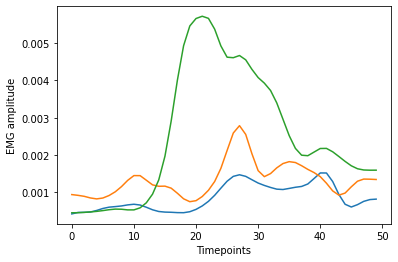

In [228]:
#In the following function, adjust the input variables direction, speed and task to extract and plot specific trials to 
#view trial- or timepoint-averaged versions of the original data.

#Task variable: a single integer between 1-4 representing P1-P4 reaching points.
#Speed: 1 for fast and 0 for slow speed
#Direction: 1 for forward and 0 for backward reaching direction
#Muscle: integers ranging from [1-9] for the following muscles respectively: [Finger extensor, brachioradialis, biceps brachii,
    #triceps medialis, triceps lateralis, anterior deltoid, posterior deltoid, pectoralis major, latissimus dorsi].
#Average: 0=Across trials, 1=Across Timepoints

def func_data(Task,Speed, Direction,Muscle, Average):
    
    print('Muscles included: ', pd.DataFrame(X).columns[Muscle].tolist())
    
    if Speed==1:
        trial=X_tensor[320:,:,:]
        print('Fast trials selected..')
    else:
        trial=X_tensor[0:320,:,:]
        print('Slow trials selected..')
    
    if Direction==0:
        trial=trial[0:160,:,:]
        print('Backward reaching direction selected...')
    else:
        trial=trial[160:,:,:]
        print('Forward reaching direction selected...')
        
    if Task==1:
        trial=trial[0:40,:,:].mean(axis=Average)
        print(trial.shape)
        print('Reaching point 1 selected...')
    elif Task==2:
        trial=trial[40:80,:,:].mean(axis=Average)
        print('Reaching point 2 selected...')
    elif Task==3:
        trial=trial[80:120,:,:].mean(axis=Average)
        print('Reaching point 3 selected...')
    else:
        trial=trial[120:160,:,:].mean(axis=Average)
        print('Reaching point 4 selected...')
    
    trial=trial[:,Muscle]
    
    if Average==0:
        print('Averaging across trials')
        plt.xlabel('Timepoints')
        plt.ylabel('EMG amplitude')
        plt.plot(trial)
    elif Average==1:
            print('Averaging across Timepoints')
            pd.DataFrame(trial).plot(kind='bar').legend(pd.DataFrame(X).columns[Muscle].tolist())
    else:
        print('Averaging across Muscles')
        
    
    
    
    
    


    
#Type in the input below!!
#What does each averaging method tell you about the data??
    
func_data(Task=1,Speed=0,Direction=1,
          Muscle=[1,2,3],Average=0)

In [319]:
#Can you get the trial-averaged data for a specific timepoint?

#Examine the code in the function above and see if you can find the trial-averaged data for a specific timepoint below:





In [306]:
#Now that you are familiar with the dataset, it is time to focus the analysis to specific tasks.
#Create a new variable called task by indexing the pandas dataframe 'Y' below to extract 
#a specific task variable that will be used later for classifications
display(Y)

##Create variable named 'task' below

task=

,TASK,Speed,Direction
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
635,16,1,1
636,16,1,1
637,16,1,1
638,16,1,1


In [87]:
#Next, we need to specify the number of components we wish to extract during the dimensionality reduction process. This
#step is vital as too few or too many extracted components gives a suboptimal representation of the original matrix. The
#appropriate model-rank is notoriously difficult to empirically determine (see doi: 10.1007/s00421-021-04604-9 for details),
#and so here we will start with an arbitrary number of your choice and demonstrate an empirical method later on....

##Specify the model rank you want to investigate using this variable:
num_components=3


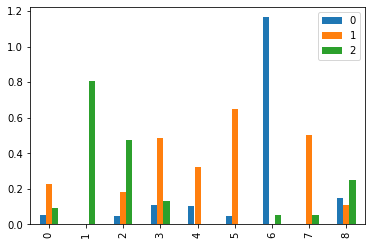

Timepoint specific activation coefficient : [[0.00088838 0.00170997 0.00179568 ... 0.00066862 0.00071824 0.00073111]
 [0.0009906  0.00104601 0.0015279  ... 0.0005921  0.00051198 0.00050004]
 [0.0002923  0.00031744 0.00037155 ... 0.00063501 0.00053203 0.00051964]]


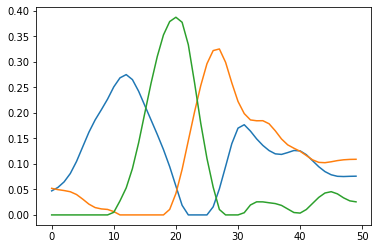

Trial-specific muscle activation coefficient : [[0.00615658 0.00563795 0.01627557 ... 0.0128287  0.0013998  0.00207688]
 [0.00821124 0.0033945  0.00173577 ... 0.00474193 0.00095474 0.00033946]
 [0.00844848 0.00218143 0.00546314 ... 0.00745296 0.00011456 0.00164034]]


In [91]:
##Non-negative matrix factorisation
##https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

model_NMF=NMF(n_components=num_components,solver='cd',
    beta_loss='frobenius',
    tol=0.0001,
    max_iter=200,
    random_state=None,
    alpha=0.0,
    l1_ratio=0.0,
    verbose=0,
    shuffle=False)

    #Below is an implementation of NNMF in the spatial domain (i.e. relative weightings in muscle activity across time)





W_spatial = model_NMF.fit_transform(abs(X).T)
H_spatial = model_NMF.components_

pd.DataFrame(W_spatial).plot(kind='bar')
plt.show()
print('Timepoint specific activation coefficient :', H_spatial)



#We can also investigate the predominant patterns in the temporal domain (i.e. covariation in EMG activity across muscles).
#The data first needs to be manipulated so as to capture this across muscle dimension...
#This involves the following reshaping...

X_temp=X.values.reshape(640, 50, 9).transpose(1,0,2).reshape(50,640*9)

W_temporal=model_NMF.fit_transform(abs(X_temp))
H_temporal = model_NMF.components_


plt.plot(W_temporal)
plt.show()
print('Trial-specific muscle activation coefficient :', H_temporal)


##Here are the hyperparameters for NNMF that you can adjust, press shift+tab while inside the function to see the options
##in detail

# 'init': The method to initialise the extracted components
# 'solver': Numerical solver to use for the optimisation problem
# 'beta_loss': the loss function
# 'tol': the Tolerance of the stopping criterion
# 'max_iter': Maximum number of iterations during timing out
# 'alpha': a constant that adjust the influence of the regularisations terms in the loss function
# 'l1_ratio': a mixing parameter that allows one to adjust the regularisation term towards either L1 or L2 penaly terms


##What is the effect of adjusting each of these hyperparameters on the output???

Explained variance ratio:  [0.58613857 0.16459327 0.09055456]
Singular values:  [1.1933785  0.63238869 0.46906521]


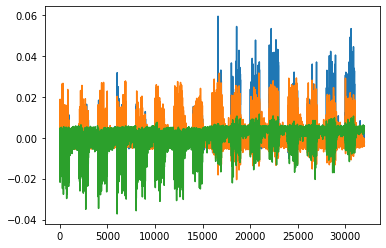

In [92]:
## Principal component analysis
## https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html


##Try what you did regarding the spatial and temporal domain analysis and the various hyperparameters here on PCA...

model_pca=PCA(n_components=num_components, copy=True, whiten=False, 
                          svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)

model_pca.fit(X)
print('Explained variance ratio: ',model_pca.explained_variance_ratio_)
print('Singular values: ', model_pca.singular_values_)

X_pca=model_pca.transform(X)

plt.plot(X_pca)

Components:  [[-2.50682293e-02 -3.63314259e-01 -2.07460117e-01 -1.74789041e-02
   7.37927063e-02 -1.49515387e-02  9.53957557e-01 -1.25109804e-01
  -5.52577556e-03]
 [-1.18603217e-01 -1.64805909e+00 -9.03374547e-01 -1.08958524e-01
   1.40151293e-01  2.67412700e-01  2.87529918e-01 -7.27444140e-02
  -4.18315147e-01]
 [-3.17495778e-01  3.67271824e-01 -3.06743122e-04 -7.90886241e-01
  -6.60956401e-01 -9.23783048e-01  7.92650435e-02 -7.55007175e-01
  -1.90040476e-02]]
Mixing values:  [[ 0.04770266 -0.06896235 -0.13537669]
 [ 0.11161159 -0.4498207   0.01243904]
 [ 0.07308041 -0.26468696 -0.07207413]
 [ 0.10646671 -0.11795065 -0.32261031]
 [ 0.1151051  -0.04398607 -0.25512662]
 [-0.01570368  0.00957895 -0.3358989 ]
 [ 1.09534039 -0.23813267 -0.04460493]
 [-0.04767805 -0.06038122 -0.29260961]
 [ 0.15090197 -0.15827207 -0.0509247 ]]
Mean values:  [0.00128441 0.00160593 0.00197845 0.00241836 0.00143746 0.00271635
 0.00601712 0.00183157 0.00171145]


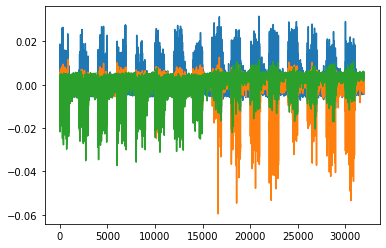

In [164]:
#Independent component analysis
##https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html

##Try what you did regarding the spatial and temporal domain analysis and the various hyperparameters here on ICA...

model_ica=FastICA(n_components=num_components, algorithm='parallel', whiten=True, 
        fun='logcosh', fun_args=None, max_iter=200, 
        tol=0.0001, w_init=None, random_state=None)
model_ica.fit(X)
print('Components: ',model_ica.components_)
print('Mixing values: ', model_ica.mixing_)
print('Mean values: ', model_ica.mean_)

X_ica=model_ica.transform(X)

plt.plot(X_ica)

In [263]:
##Lets compare the performance of NNMF, PCA and ICA at this arbitrary model-rank using a well known metric
##The Variance accounted for (VAF)

#Here is the code to compute the VAF on the spatial NNMF output


reconstructed_matrix=np.dot(W_spatial,H_spatial)
SSE=np.sum(np.linalg.norm(np.subtract(abs(X),reconstructed_matrix.T),'fro')**2)
SST=np.sum(np.linalg.norm(np.subtract(abs(X).values,pd.DataFrame(X.mean(axis=1)).values),'fro')**2)
VAF=1-(SSE/SST)
print('Spatial NNMF VAF: ',VAF)

#Can you do the same for NNMF in the temporal domain?

#Can you compute the VAF from the PCA and ICA results also in both the spatial and temporal domains?

Spatial NNMF VAF:  0.8178553000409469


(640, 3)
Variance accounted for:  0.7782610267524264


<AxesSubplot:>

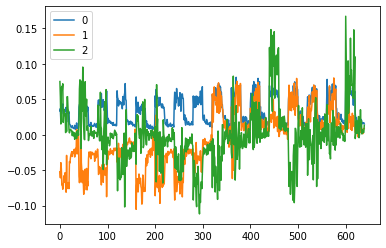

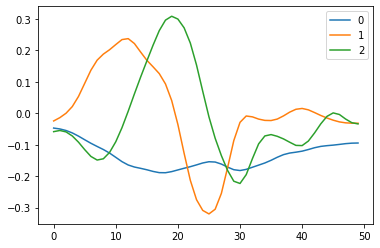

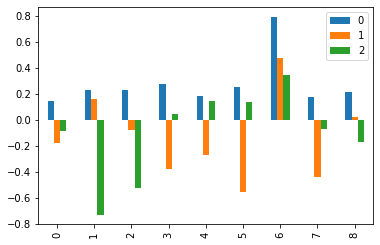

In [283]:
##Tensor decompositions: Tucker decomposition
##http://tensorly.org/stable/user_guide/tensor_decomposition.html

#Lets input the EMG data across all trials, timepoints and muscles as a tensor into a Tucker decomposition.

#Firstly we reshape the data into 3 dimensions
X_tensor=tl.tensor(X.values.reshape(640,50,9))

#Then using the Tensorly package, use this tensor as input in the following manner:

core, factors_tuck = tucker(X_tensor ,rank=[num_components,num_components,num_components])

#This results in two outputs, a core and an array of factors. The factors are what we are interested in here as they
#represent the spatial, temporal and trial specific components of the original dataset

#We can also vary the number of the individual components we extract as shown below:

cores, factors = tucker(X_tensor ,rank=[3,3,4])

#To index into the factors array and find the components of interest, you can do so in the following manner:

factors[0]    #Trial-specific components
factors[1]    #Temporal components
factors[2]    #Spatial components



#Using a function provided by Tensorly you can reconstruct the original tensor using the output components as follows:
tucker_recon=tucker_to_tensor([core, factors_tuck])


#And compute the VAF as before:
SSE=np.sum(np.linalg.norm(np.subtract(X_tensor,tucker_recon))**2)
SST=np.sum(np.linalg.norm(X_tensor)**2)
VAF_tuck=1-SSE/SST
print('Variance accounted for: ',VAF_tuck)



pd.DataFrame(factors_tuck[0]).plot()
pd.DataFrame(factors_tuck[1]).plot()
pd.DataFrame(factors_tuck[2]).plot(kind='bar')

Variance accounted for:  0.7246088589623135


<AxesSubplot:>

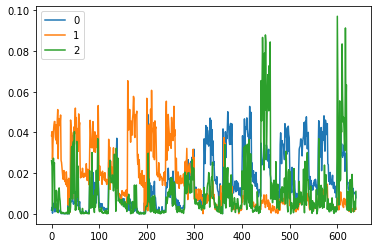

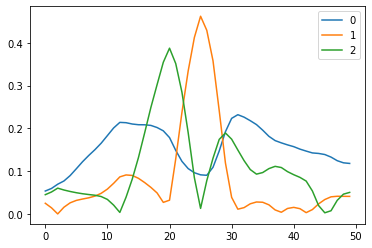

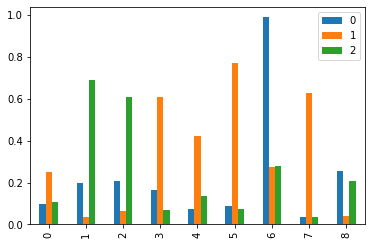

In [285]:
##Tensor decompositions: Non-negative Tucker
##http://tensorly.org/stable/user_guide/tensor_decomposition.html


#Try to replicate the above computation on a Tucker decomposition with non-negative constraints. Save the VAF value as
# 'VAF_nnt' so we can save it for later use

X_tensor=tl.tensor(X.values.reshape(640,50,9))
core, factors_nnt =non_negative_tucker(X_tensor ,rank=[num_components,num_components,num_components])

tucker_recon=tucker_to_tensor([core, factors_nnt])

#Implement your code here

print('Variance accounted for: ',VAF_nnt)

pd.DataFrame(factors_nnt[0]).plot()
pd.DataFrame(factors_nnt[1]).plot()
pd.DataFrame(factors_nnt[2]).plot(kind='bar')

Variance accounted for:  0.7748778428226084


<AxesSubplot:>

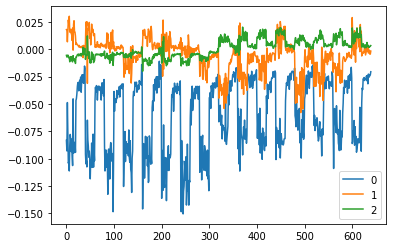

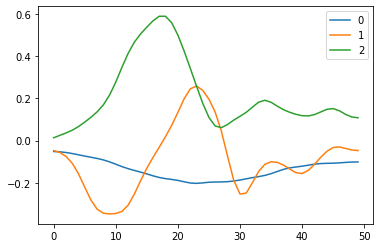

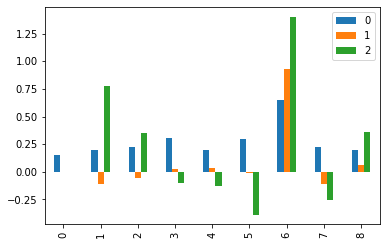

In [287]:
##Tensor decompositions: PARAFAC Decomposition
##http://tensorly.org/stable/user_guide/tensor_decomposition.html

#Implement a different tensor decomposition method known as PARAFAC or Canonical Decomposition

#As before, we begin with a tensor
X_tensor=tl.tensor(X.values.reshape(640,50,9))

#Using a funciton provided by the Tensorly package, we implement the PARAFAC decomposition:
factors_para = parafac(X_tensor ,rank=num_components)

#We reconstruct the original data and compute the VAF:
parafac_recon=tl.cp_to_tensor(factors_para)
SSE=np.sum(np.linalg.norm((X_tensor-parafac_recon))**2)
SST=np.sum(np.linalg.norm(X_tensor)**2)
VAF_para=1-SSE/SST
print('Variance accounted for: ',VAF_para)


pd.DataFrame(factors_para[1][0]).plot()
pd.DataFrame(factors_para[1][1]).plot()
pd.DataFrame(factors_para[1][2]).plot(kind='bar')

Variance accounted for:  0.7748778428226084


<AxesSubplot:>

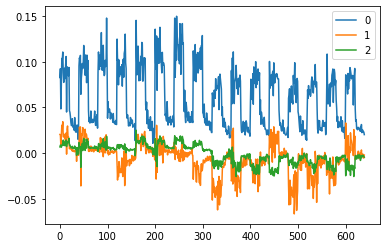

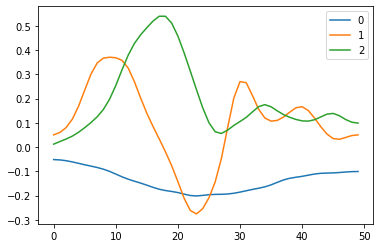

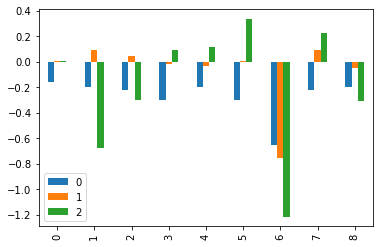

In [304]:
##Tensor decompositions: Orthogonal-PARAFAC Decomposition
##http://tensorly.org/stable/user_guide/tensor_decomposition.html

#Implement a PARAFAC decomposition that is orthogonally constrained:

#As before, we begin with a tensor
X_tensor=tl.tensor(X.values.reshape(640,50,9))


#Using a function provided by the Tensorly package, we implement the Orthogonal PARAFAC decomposition:
factors_orthpara = parafac(X_tensor ,rank=num_components,orthogonalise=True)

#We reconstruct the original data and compute the VAF:
parafac_recon=tl.cp_to_tensor(factors_para)
SSE=np.sum(np.linalg.norm((X_tensor-parafac_recon))**2)
SST=np.sum(np.linalg.norm(X_tensor)**2)
VAF_orthpara=1-SSE/SST
print('Variance accounted for: ',VAF_orthpara)



#What differences are there with the previous PARAFAC output?
pd.DataFrame(factors_orthpara[1][0]).plot()
pd.DataFrame(factors_orthpara[1][1]).plot()
pd.DataFrame(factors_orthpara[1][2]).plot(kind='bar')



LDA Accuracy score:  0.9791666666666666


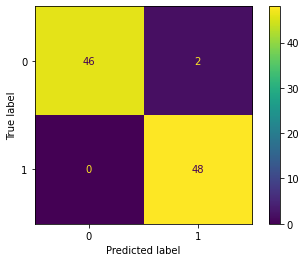

In [309]:
## Decode the task variable you selected using the underlying parameters trial-specific coefficients 
#from the above tensor decompositions
## For the Task1-16 variable, a decoding accuracy >1/16 is significant and so on for the other variables.
## https://www.frontiersin.org/articles/10.3389/fncom.2013.00008

#Here is an example implementation using Linear discriminant analysis on the Tucker decomposition output

#Split the trial-specific activation coefficients and the task variable into training and testing groups as follows:

X_train, X_test, y_train, y_test=train_test_split(factors_tuck[0],task,train_size=0.85,stratify=task)

#Adjust the training size above to whatever percentage you see fit...

#Initialise the LDA model
model=LDA()
#Fit the training data to the model
model.fit(X_train,y_train)

#Use the fitted model to task category of the unseen test data
y_pred=model.predict(X_test)
#Determine the accuracy score by constrasting the predictions against the actual task output
print('LDA Accuracy score: ',accuracy_score(y_test,y_pred))
LDA_acc_tuck=accuracy_score(y_test,y_pred)

#Plot a confusion matrix to show the true/false positives and negatives
plot_confusion_matrix(model,X_test,y_test)

#Always put the following statement at the end of a piece of code with plots 
plt.show()



##Now carry out the above using the trial-specific components from different tensor decompositions

##Once you have done that, try the same using different classifiers, for example:

    #Naive-Bayes
    #https://scikit-learn.org/stable/modules/naive_bayes.html

    ##K-Nearest Neighbors
    ##https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html

In [310]:
##Can you find the tensor decomposition model that gives the best output in terms of the VAF vs Task-decoding trade-off??





##Create a for loop that iterates from the model ranks 1-10 as the input parameter for each tensor decomposition and compute
#the VAF and task discrimination accuracy for all.





#Get both the VAF and Accuracy score for the presented tensor decompositions and compare them in terms of this trade-off..
#Read through the following paper on how you can get a summary statistic to represent this trade-off





MLP Accuracy score:  0.96875


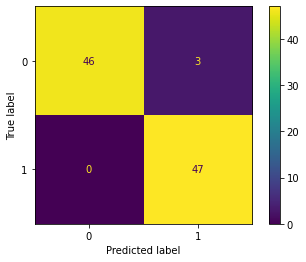

In [313]:
##Deep learning##

##Below you can find the code setup for a multi-layer perceptron (MLP_, the simplest form of neural network.
##Who's output layer is applicable to classification problems


##Pick the output from a tensor decomposition to use as input into the MLP, set Type=1 for Tucker, 2 for Non-negative tucker
##3 for PARAFAC and 4 for Orthogonal PARAFAC. Note that the MLP is sensitive to the magnitude of the input variables 
#and therefore it is necessary to standardise them


##Look across the web for a general rule for how many layers and nodes one should have in a neural network and see if it
##produces the best results here.


Type=4

if Type==1:
    X_mlp=factors_tuck[0]
elif Type==2:
    X_mlp=factors_nnt[0]
elif Type==3:
    X_mlp=factors_para[1][0]
else:
    X_mlp=factors_orthpara[1][0]



#Split the data into training and testing groups
X_train, X_test, y_train, y_test=train_test_split(X_mlp,task.values,train_size=0.85)

#Initialise the standardiser and fit it to the data as follows:
scaler= StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Initialise the MLP and fit the training data
clf = MLPClassifier(solver='adam', alpha=1e-5,
                     hidden_layer_sizes=(75,25), random_state=1)

clf.fit(X_train, y_train)

#Make predictions and check the accuracy
y_preds=clf.predict(X_test)
print('MLP Accuracy score: ',accuracy_score(y_test,y_preds))
plot_confusion_matrix(clf ,X_test,y_test)
plt.show()

In [318]:
##Try to construct your own neural network that can classify the right reaching task...here is an example using the Keras framework
##https://keras.io/

##Pick the output from a tensor decomposition to use as input into the MLP, set Type=1 for Tucker, 2 for Non-negative tucker
##and 3 for PARAFAC. Note that the neural network is sensitive to the magnitude of the input variables and therefore it is necessary to
##standardise them

Type=4

if Type==1:
    X_NN=factors_tuck[0]
elif Type==2:
    X_NN=factors_nnt[0]
elif Type==3:
    X_NN=factors_para[1][0]
else:
    X_NN=factors_orthpara[1][0]

    
##This neural network cannot take multiple classes as a target variable, therefore we must encode the target variable
##as a set of binary integers
# encode class values as integers


if task.name=='Task':
    encoder = LabelEncoder()
    encoder.fit(task)
    encoded_Y = encoder.transform(task)
    # convert integers to dummy variables (i.e. one hot encoded)
    dummy_y = np_utils.to_categorical(encoded_Y)
    X_train, X_test, y_train, y_test=train_test_split(X_NN,dummy_y,train_size=0.85)
else:
    X_train, X_test, y_train, y_test=train_test_split(X_NN,task.values,train_size=0.85)
    
##As with the MLP above, the neural network is sensitive to differences in magnitude between predictor variables that may not
##necessarily be informative...therefore we will scale the input data accordingly
scaler= StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)





##Here are some parameters you can adjust to optimise the neural network, how do these adjustments effect the output??:

#The number of neurons in the layer
#The number of layers
#The activation function
#The loss function
#The optimizer
#The metrics
#The training epochs
#The batch size
#The number of cross-validations




def NeuralNet_model():
# create model
    model = Sequential()
    model.add(Dense(50, input_dim=num_components, activation='relu'))
    #Add another network layer here:
    #model.add(Dense(50, input_dim=num_components, activation='relu'))
    
    #The final layer has a softmax activation function so as to give a single value estimate
    model.add(Dense(np.unique(task)[-1], activation='softmax'))
    
# Compile model
    model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train,y_train)
    return model

#Cross-validate the results
estimator = KerasClassifier(build_fn=NeuralNet_model, epochs=200, batch_size=1, verbose=0)
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X_test, y_test, cv=kfold)
print("Cross validated score (Mean (Std)): %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

17/17 [==============================] - 0s 877us/step - loss: 0.0000e+00 - accuracy: 0.4370


17/17 [==============================] - 0s 939us/step - loss: 0.0000e+00 - accuracy: 0.5390


17/17 [==============================] - 0s 931us/step - loss: 0.0000e+00 - accuracy: 0.5019


17/17 [==============================] - 0s 812us/step - loss: 0.0000e+00 - accuracy: 0.5006


Cross validated score (Mean (Std)): 53.16% (4.21%)
